# Прогнозирование оттока: отчет о проведенном исследовании

## 1\. Цели и задачи проекта

Требуется построить модель для прогнозирования оттока клиентов оператора мобильной связи, позволяющую заблаговременно выявлять сегмент пользователей, склонных к оттоку и принимать меры по их удержанию, а также оценить качество модели и ее экономический потенциал.

## 2\. Описательный анализ данных

Для построения модели предлагается использовать закрытые данные. Известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными. Метки классов: 1 - отток, -1 - не отток.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import model_selection, linear_model, feature_selection, ensemble, metrics
from sklearn.utils import class_weight
import category_encoders as ce
import imblearn
from imblearn.pipeline import Pipeline
import scipy
from scipy.stats import chi2_contingency
from scipy import optimize
import statsmodels
from statsmodels.sandbox.stats.multicomp import multipletests
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 12
import seaborn as sns

In [3]:
print(pd.__version__)
print(sklearn.__version__)
print(ce.__version__)
print(imblearn.__version__)
print(scipy.__version__)
print(statsmodels.__version__)

1.2.3
0.24.2
2.2.2
0.7.0
1.5.4
0.12.1


In [4]:
train_data = pd.read_csv('orange_small_churn_data.train')
train_labels = pd.read_csv('orange_small_churn_labels.train', header=None, names=['y_true'])

In [5]:
print("Доля классов отток/ не отток: %f/ %f" 
      %(np.sum(train_labels == 1) / train_labels.size, np.sum(train_labels == -1) / train_labels.size))

Доля классов отток/ не отток: 0.074400/ 0.925600


В данных имеются признаки, заполненные NA, а также признаки с нулевой дисперсией:

In [6]:
useless_features = train_data.columns[train_data.isna().all()]\
.append(train_data.std().index[train_data.std() == 0])

print(*useless_features, sep=', ')

Var8, Var15, Var20, Var31, Var32, Var39, Var42, Var48, Var52, Var55, Var79, Var141, Var167, Var169, Var175, Var185, Var209, Var230, Var118


### Корреляции переменных с целевой функцией

**1\. Числовые переменные**

Для числовых переменных рассчитаем разность их математических ожиданий в разрезе классов:

$\dfrac{\mathbb{E}(X|y=1) - \mathbb{E}(X|y=-1)}{\text{max}(X)-\text{min}(X)}$

In [7]:
def expect_diff(var, labels=train_labels, scale=True):
    '''
    Возвращает разницу средних в разрезе классов, нормированную на размах вариации
    '''
    means = pd.DataFrame(var).assign(labels=labels).groupby(['labels']).mean()
    corr = (means.iloc[1] - means.iloc[0]) / (var.max() - var.min())
    
    return (corr.index[0], corr.values[0]) if scale else diff

numeric_corr = [expect_diff(train_data[var]) for var in train_data.iloc[:,:190] if var not in useless_features]

numeric_top = pd.DataFrame(numeric_corr, columns=['var_name', 'corr'])\
.set_index('var_name')\
.applymap(abs)\
.sort_values('corr', ascending=False)

**Топ 20 числовых переменных по их влиянию на целевую функцию:**

In [8]:
print(*numeric_top.head(20).index, sep=', ')

Var188, Var130, Var189, Var114, Var73, Var111, Var126, Var7, Var177, Var168, Var139, Var53, Var142, Var92, Var144, Var147, Var69, Var136, Var110, Var51


**Антитоп 20:**

In [9]:
print(*numeric_top.tail(20).index, sep=', ')

Var24, Var138, Var96, Var163, Var85, Var4, Var25, Var121, Var146, Var21, Var22, Var181, Var109, Var112, Var105, Var104, Var83, Var129, Var44, Var123


**2\. Категориальные переменные**

Для категориальных переменных рассчитаем коэффициенты V Крамера: 

$\phi_c(X_1^n,X_2^n) = \sqrt{\dfrac{\chi^2(X_1^n, X_2^n)}{n\;(\text{min}(K_1,K_2)-1)}}$

Значимость корреляций проверим с помощью статистики хи-квадрат с поправкой Бенджамини-Хохберга.

In [10]:
# Список категориальных признаков
categor_vars = train_data.loc[:,'Var191':].columns.difference(useless_features)

# Таблицы сопряженности
crosstabs = [pd.crosstab(train_data[var], train_labels['y_true']) for var in categor_vars]

# Проверка условий применимости критерия хи-квадрат
chi2_terms = [np.sum(tab < 5).sum() / tab.size < 0.2 if tab.shape[0] > 1 else False\
              for tab in crosstabs]

# Статистика хи-квадрат, p-value и переменные, для которых условия выполняются
chi2_tests = [chi2_contingency(tab)[:2] + (num,) \
              for num, tab in enumerate(crosstabs) if chi2_terms[num]]

def cramersV(chi2, tab):
    '''
    Вычисляет коэффициент V Крамера
    '''    
    return np.sqrt(chi2/(tab.sum().sum()*(np.min(tab.shape)-1)))

# Значимые коэффициенты V Крамера, p-value и соответствующие имена переменных
V_coef = [(cramersV(stat[0], crosstabs[stat[2]]), stat[1], categor_vars[stat[2]])\
          for stat in chi2_tests if stat[1] < 0.05]

categor_top = pd.DataFrame(V_coef, columns=['cramers_V', 'p_value', 'var_name'])\
.assign(p_corrected = lambda x: multipletests(x.p_value, alpha = 0.05, method = 'fdr_bh')[1])\
.sort_values(['cramers_V', 'p_value'], ascending=False)

categor_top.set_index('var_name')

,cramers_V,p_value,p_corrected
var_name,,,
Var206,0.080985,2.662850e-38,1.331425e-37
Var205,0.073836,3.007666e-46,3.007666e-45
Var204,0.069023,9.189547e-08,1.021061e-07
Var227,0.055619,2.666712e-24,8.889041e-24
Var221,0.049119,1.342547e-18,2.237578e-18
Var210,0.048540,8.606806e-19,1.721361e-18
Var226,0.048516,6.673381e-11,9.533401e-11
Var218,0.044709,6.745818e-19,1.686455e-18
Var225,0.032579,4.034848e-05,4.034848e-05


## 3\. Методика измерения качества и критерий успеха

Хочется выявить максимальное число пользователей, склонных к оттоку, т.е. максимизировать Recall, с другой стороны это занижает Precision, т.е. повышаются расходы на удержание неверно классифицированных пользователей. Поэтому при подборе оптимальных параметров классификатора будем использовать их гармоническое среднее, т.е. F1-score. Качество работы алгоритма будем оценивать по ROC-AUC. 

Для участия в кампании по удержанию оттока будем привлекать топ пользователей, отсортированных по вероятности принадлежности к классу отток. Для определения оптимального размера топа будем оптимизировать экономическую модель, оценивающую эффект от удержания оттока.

Критерием успешности будем считать такую модель, предсказания которой дают положительный экономический эффект, при этом средняя стоимость удержания одного пользователя не превышает 20\% от среднего дохода с одного пользователя. 

## 4\. Техническое описание решения

Для обработки данных используем следующий Pipeline:<br />
1\. Удаляем признаки, заполненные NA, а также признаки с нулевой дисперсией. Удаляем числовые и категориальные признаки, имеющие низкую корреляцию с целевой переменной.<br />
2\. Пропуски в числовых признаках заполняем средними, после чего масштабируем с помощью StandardScaler и отправляем в трансформер для объединения с категориальными признаками.<br />
3\. Пропуски в категориальных признаках заполняем нулями, после чего кодируем HelmertEncoder и отправляем в трансформер для объединения с числовыми признаками.<br />
4\. Обучаем регрессионную модель с L1-регуляризатором для отбора признаков.<br />
5\. Отбираем важные признаки.<br />
6\. Обучаем классификатор градиентного бустинга с весами  отток/не отток = 3/1. 

In [11]:
# Бесполезные признаки, заполненные NA, а также признаки с нулевой дисперсией
train_data.drop(useless_features, axis=1, inplace=True)

# Антитоп 20 числовых признаков, имеющих низкую корреляцию с целевой переменной  
train_data.drop(numeric_top.tail(20).index, axis=1, inplace=True)

# Категориальные признаки, не коррелирующие с целевой переменной
train_data.drop(categor_vars.difference(categor_top.var_name).difference(useless_features), axis=1, inplace=True)

X_train, X_test, y_train, y_test = \
model_selection.train_test_split(train_data, train_labels, test_size=0.2, random_state=1)

# Списки числовых и категориальных призаков
numeric_vars = X_train.loc[:,:'Var190'].columns
categor_vars = categor_top.var_name

# Трансформер для числовых переменных (обработка пропусков, масштабирование)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())])

# Трансформер для категориальных переменных (обработка пропусков, кодирование)
categor_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('encoder', ce.helmert.HelmertEncoder())])

# Сборка в один трансформер
preprocessor = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_vars),
    ('categor_transformer', categor_transformer, categor_vars)])

# Классификатор для отбора признаков
lasso = linear_model.Lasso(alpha=0.005, random_state=1)

# Отбор признаков
feature_selector = feature_selection.SelectFromModel(lasso)

# Классификатор для прогнозирования оттока
gb_clf = ensemble.GradientBoostingClassifier(random_state=1)

# Параметры для оптимизации
param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.001, 0.01, 0.05, 0.1], 
              'max_depth': [2, 3, 4, 5]}

# Подбор оптимальных параметров
clf_cv = model_selection.RandomizedSearchCV(
    gb_clf, param_distributions=param_grid, cv=3, scoring='recall', random_state=1, n_iter=30, n_jobs=-1)

# Трансформер признаков, подбор оптимальных параметров
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('estimator', clf_cv)])

# Расчет весов
sample_weight = class_weight.compute_sample_weight(class_weight={1: 3, -1: 1}, y=y_train)

# Параметры для классификатора
kwargs = {pipeline.steps[-1][0] + '__sample_weight': sample_weight}

Оптимальные параметры классификатора:

In [13]:
pipeline.fit(X_train, y_train, **kwargs)
pipeline.steps[-1][1].best_params_

{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1}

## 5\. Качество модели и ожидаемый экономический эффект от удержания оттока

Оценка качества на тестовой выборке:

In [14]:
print('ROC-AUC:', metrics.roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1]))

ROC-AUC: 0.7283742172822072


Результаты классификации:

In [15]:
churn_data = y_test.assign(proba = pipeline.predict_proba(X_test)[:,1]).rename(columns={0: 'y_true'})
churn_data

,y_true,proba
3841,-1,0.020181
12898,-1,0.015288
15032,-1,0.066556
36781,-1,0.059729
9201,-1,0.238265
...,...,...
30258,-1,0.420816
20563,-1,0.213795
20275,-1,0.022015
10121,-1,0.373025


Полученные данные будем использовать для оценки ожидаемого экономического эффекта от удержания оттока.

### 1\. Простая экономическая модель

Для начала будем считать, что среднее число активных пользователей, а также баланс классов не изменяются, т.е. каждый месяц приходит и уходит равное число пользователей.

Формула для расчета ожидаемого ежемесячного экономического эффекта:

**ECONOMIC IMPACT = CAMPAIGN PROFIT – CASUAL PROFIT**,

где ECONOMIC IMPACT – экономический эффект, CAMPAIGN PROFIT – прибыль от кампании по удержанию оттока, CASUAL PROFIT – прибыль при неконтролируемом оттоке.

**CASUAL PROFIT = (USERS – CHURN) $\cdot$ INCOME**,

где USERS – всего пользователей, CHURN – потеряно пользователей при неконтролируемом оттоке, INCOME – средний доход с одного пользователя.

**CAMPAIGN PROFIT = (USERS – LOSS) $\cdot$ INCOME – CAMPAIGN COST**,

где LOSS – потеряно пользователей в ходе кампании, CAMPAIGN COST – стоимость кампании по удержанию оттока.

**CAMPAIGN COST = USERS IN CAMP – RETAIN COST**,

где USERS IN CAMP – пользователей, участвующих в кампании, RETAIN COST – средняя стоимость удержания одного пользователя.

**LOSS = CHURN IN CAMP $\cdot$ (1 – PROB) $\cdot$ CHURN OUT CAMP**,

где CHURN IN CAMP – число пользователей класса отток, участвующих в кампании, CHURN OUT CAMP – число пользователей класса отток, не участвующих в кампании, PROB – вероятность, с которой пользователь принимает предложение.

Вероятность, с которой пользователь принимает предложение в ходе кампании, должно быть связана со стоимостью его удержания. Для моделирования этой взаимосвязи будем использовать функцию:

$f(x) = \dfrac{1}{1 + e^{-kx}}$

При небольших затратах на кампанию вероятность принятия предложения растет медленно (поскольку выделенные на удержание оттока средства просто не позволяют сделать стоящее преложение), так же как и при чрезмерно высоких расходах (здесь останутся пользователи, которые уйдут независимо от качества предложения). Основной прирост вероятности происходит при средних затратах.

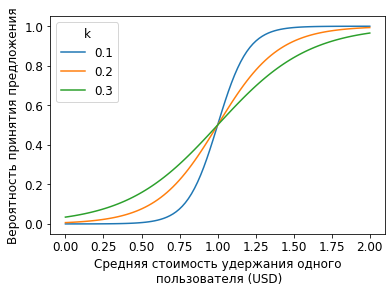

In [16]:
def norm(x, x_range):
    ''' Нормирует x в интервале x_range       
    '''
    return  (x - x_range[0])*2 /(x_range[1] - x_range[0]) - 1

def sigmoid(x, k=0.1):
    ''' k регулирует наклон сигмоиды 
    '''
    return 1 / (1 + np.exp(-x / k)) 


x = np.linspace(0,2,100)

for k in (0.1,0.2,0.3):
    plt.plot(x, sigmoid(norm(x, x_range=(x.min(), x.max())), k=k), label=k)
plt.ylabel('Вероятность принятия предложения')
plt.xlabel('Средняя стоимость удержания одного\n пользователя (USD)')
plt.legend(title='k');

Параметр k определяет темп роста вероятности, с которой пользователь принимает предложение, при увеличении расходов на его удержание, введен, чтобы смоделировать несколько иcходов кампаний. 

In [17]:
def economic_impact(income_per_user, retain_cost, churn_top, agree_proba=None, cost_thr=None, k=0.1, 
                    churn_data=churn_data):
    '''
    Функция рассчитывает ожидаемый ежемесячный экономический эффект (на одного пользователя)
     от кампании по удержанию оттока 
    
    income_per_user - средний доход с одного пользователя
    retain_cost - средняя стоимость удержания одного пользователя
    churn_top - топ пользователей, участвующих в кампании
    agree_proba - вероятность, с которой пользователь принимает предложение 
    cost_thr - пороговое значение затрат на удержание оттока, при котором вероятность, с которой
     предложение будет принято стремится к 1
    k - определяет темп роста вероятности, с которой пользователь принимает предложение, при увеличении
     расходов на его удержание 
    
    '''
    
    # Если верояность, с которой предложение будет принято, не задана, вычисляем по
    # средней стоимости удержания одного пользователя
    if not agree_proba:
        agree_proba = sigmoid(norm(x=retain_cost, x_range=[0, cost_thr]), k=k)
   
    # Общее число пользователей
    total_users = churn_data.shape[0]

    # Пользователи, участвующие в кампании
    campaign_users = churn_data.sort_values('proba', ascending=False)\
    .head(int(total_users * churn_top))

    # Стоимость кампании по удержанию оттока
    campaign_cost = campaign_users.shape[0] * retain_cost

    # Число пользователей, которых не удалось удержать
    wasted_users = campaign_users.query('y_true == 1').shape[0] * (1 - agree_proba)

    # id потерянных в ходе кампании пользователей
    wasted_users_id = campaign_users.query('y_true == 1').head(int(wasted_users)).index
    
    # id пользователей класса отток, не участвующих в кампании
    churn_users_id = churn_data.loc[churn_data.index.difference(campaign_users.index),:]\
    .query('y_true == 1').index
 
    # Общее число потерянных пользователей
    churn_users = wasted_users + churn_users_id.shape[0]
    
    # id всех потерянных пользователей
    churn_users_id = churn_users_id.append(wasted_users_id)

    # Прибыль от кампании
    campaign_profit = (total_users - churn_users) * income_per_user - campaign_cost

    # Количество потерянных пользователей, если не проводить компанию 
    churn_users = churn_data.query('y_true == 1').shape[0]

    # Прибыль, если не проводить кампанию
    profit = (total_users - churn_users) * income_per_user

    # Эффект от удержания оттока
    economic_impact = campaign_profit - profit
    
    # Экономический эффект, нормированный на число пользователей, 
    # экономический эффект,
    # id всех потерянных пользователей
    return economic_impact / churn_data.shape[0], economic_impact, churn_users_id

Для моделирования кампаний по удержанию оттока будем использовать следующие параметры:<br />
1\. Средний доход с одного пользователя - 10 USD.<br />
2\. Средняя стоимость удержания одного пользователя - не более 5 USD.<br />
3\. Средняя стоимость удержания одного пользователя, при которой вероятность принятия предложения стремится к 1 - 2 USD.<br />
4\. Темп роста вероятности, с которой пользователь принимает предложение, при увеличении расходов на его удержание - k = 0.1, 0.2, 0.3.<br />
5\. Число активных пользователей - 50 000 000 человек.<br />
6\. Топ пользователей для участия в кампании - параметр оптимизации. Поскольку функция не гладкая, используем дифференциальную эволюцию. 

In [18]:
n_users = 50e6
income_per_user = 10
cost_thr = 2

In [19]:
k_range = [0.1, 0.2, 0.3]
retain_cost_range = np.arange(0.1,5,0.1)
opt_res = []

for k in k_range:
    for retain_cost in retain_cost_range:        
        
        def impact_func(churn_top):
            ''' 
            Функция для оптимизации экономического эффекта по топу пользователей, 
            участвующих  в кампании
            '''
            return -economic_impact(income_per_user=income_per_user, retain_cost=retain_cost, 
                                    churn_top=churn_top, cost_thr=cost_thr, k=k)[0]          
        
        # Оптимизация топа пользователей, участвующих в кампании
        opt_res.append((-optimize.differential_evolution(impact_func, bounds=((0,1), )).fun, k, retain_cost))

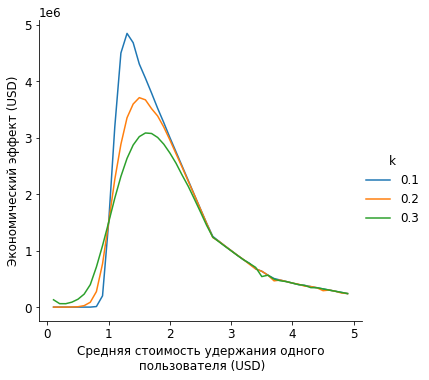

In [20]:
sns.relplot(data=pd.DataFrame(opt_res, columns=['profit', 'k', 'retain_cost'])\
            .assign(profit = lambda x: x.profit*n_users), 
            x="retain_cost", y="profit", hue="k", kind="line", palette="tab10")
plt.ylabel("Экономический эффект (USD)")
plt.xlabel("Средняя стоимость удержания одного\n пользователя (USD)");

Экономический эффект от удержания оттока зависит от расходов на кампанию и эффективности самой кампании (учитывается коэффициентом k на графике). При среднем числе активных пользователей 50 000 000 человек и среднем месячном доходе с одного пользователя 10 USD ожидаемый экономический эффект может достигать порядка 5 000 000 USD. 

### 2\. Модель, учитывающая динамику оттока пользователей

Теперь проведем численный эксперимент в тестовой группе из 8 000 человек. Кампания продолжается 12 итераций. На каждой итерации будем оптимизировать топ пользователей для участия в кампании. Будем считать, что за одну итерацию (условно месяц) уходят пользователи, которых не удалось удержать. Таким образом, теряем сразу всех, кого не удалось правильно классифицировать, и часть пользователей, участвующих в кампании, затем каждую итерацию еще какую-то часть пользователей класса отток. 

In [21]:
def economic_impact_(data=churn_data, time_period=12):
    '''
    Функция рассчитывает суммарный экономический эффект от кампании по удержанию оттока в течении 
    заданного периода времени
    
    '''    
    optimize_results, profit, churn_users_id = [], [], []

    for period in range(time_period):
        
        # Отток пользователей
        data = data.drop(churn_users_id, axis=0)

        def impact_func(param):
            ''' 
            Функция для оптимизации экономического эффекта по 2 параметрам:
            * топу пользователей, участвующих  в кампании 
            * средней стоимости удержания одного пользователя
            '''
            return -economic_impact(income_per_user=income_per_user, retain_cost=param[1], churn_top=param[0], 
                                    cost_thr=cost_thr, churn_data=data)[1]    

        # Граничные условия
        bounds = ((0,1), (0,2), )      

        # Оптимизация
        optimize_results.append(optimize.differential_evolution(impact_func, bounds=bounds))

        # Эффект от кампании
        profit.append(sum(profit) + np.abs(optimize_results[period].fun))

        # id потерянных пользователей
        churn_users_id = economic_impact(income_per_user=income_per_user, 
                                         retain_cost=optimize_results[period].x[1], 
                                         churn_top=optimize_results[period].x[0], 
                                         cost_thr=cost_thr, 
                                         churn_data=data)[2]        

    return profit

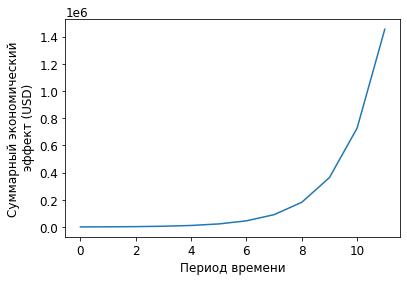

In [22]:
plt.plot(range(12), economic_impact_())
plt.xlabel('Период времени')
plt.ylabel('Суммарный экономический\n эффект (USD)');

Ожидаемый экономический эффект за расчетный период (условно 12 месяцев) в группе из 8 000 человек (при условии, что исходное число пользователей, склонных к оттоку, остается постоянным) может составить порядка 1 400 000 USD.

## 6\. Рекомендации по внедрению в продакшн

### 1\. A/B тест

Следует выделить 2 небольшие группы пользователей, в одной из которых вести кампании по удержанию оттока, во второй - не контролировать отток пользователей. Модель тестировать в течении, например, года, после чего оценить экономический эффект. В процессе тестирования стоит провести опросы и онлайн-тестирование с целью получения новых признаков, которые помогут улучшить качество модели.

### 2\. Оценка экономического эффекта от улучшения качества модели

Проведем моделирование кампаний, в которых качество модели выше на 0.5 и 1\%. Для этого будем удалять из результатов классификации пользователей, на которых ошибка классификации наибольшая, при этом каждый раз будем пересчитать ROC-AUC.

In [23]:
def churn_set(boost, data=churn_data):
    '''
    Функция возвращает сабсэт с результатами классификация, выбрасывая объекты класса 
    не отток (-1) с высокой вероятностью оттока
    boost - процент, на который должна вырасти площадь под ROC-кривой
    
    '''
    
    data_ = data.copy()
    score = []
    churn_index = data.sort_values('proba', ascending=False).query('y_true == -1').index
    
    for i in range(400):
        data_ = data_.drop(churn_index[i], axis=0)
        score.append(metrics.roc_auc_score(data_.y_true, data_.proba))

    score_boost = score / score[0]
   
    return data.drop(churn_index[: np.sum(score_boost < boost*0.01 + 1)], axis=0)

Расчеты повторяем на 10 случайных выборках из 4000 пользователей. 

In [24]:
n_samples = 4000

np.random.seed(0)
seeds = np.random.randint(1000, size=(10,3))

profit = [(economic_impact_(churn_data.sample(n_samples, random_state=seed[0]))[-1],
           economic_impact_(churn_set(0.5, churn_data.sample(n_samples, random_state=seed[1])))[-1],
           economic_impact_(churn_set(1.0, churn_data.sample(n_samples, random_state=seed[2])))[-1]) \
          for seed in seeds]

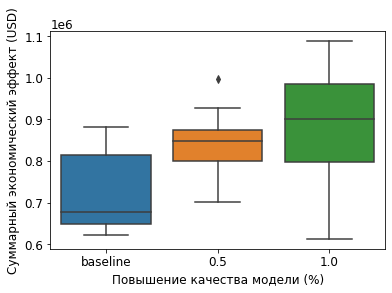

In [25]:
sns.boxplot(x="variable", y="value", 
            data=pd.DataFrame(profit, columns=['baseline', '0.5', '1.0'])\
            .melt(value_vars=['baseline', '0.5', '1.0']))
plt.xlabel('Повышение качества модели (%)')
plt.ylabel('Суммарный экономический эффект (USD)');

Точечные оценки разности медиан:

In [26]:
print('0.5% ROC-AUC raise: {:.2f} USD\n1.0% ROC-AUC raise: {:.2f} USD'.format(
    np.median(np.array(profit)[:,1]) - np.median(np.array(profit)[:,0]),
    np.median(np.array(profit)[:,2]) - np.median(np.array(profit)[:,0])))

0.5% ROC-AUC raise: 170738.47 USD
1.0% ROC-AUC raise: 224118.58 USD


Интервальные оценки разности медиан:

In [27]:
def get_bootstrap_samples(data, n_samples=1000):
    ''' Возвращает бутстрэп псевдо-выборки
    '''
    np.random.seed(0)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    ''' Возвращает доверительный интервал
    '''
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return np.round(boundaries, 2)

# Медианы
baseline_scores = list(map(np.median, get_bootstrap_samples(np.array(profit)[:,0], 1000)))
raised05_scores = list(map(np.median, get_bootstrap_samples(np.array(profit)[:,1], 1000)))
raised10_scores = list(map(np.median, get_bootstrap_samples(np.array(profit)[:,2], 1000)))

# Разница медиан
raised05_delta_scores = list(map(lambda x: x[1] - x[0], zip(baseline_scores, raised05_scores)))
raised10_delta_scores = list(map(lambda x: x[1] - x[0], zip(baseline_scores, raised10_scores)))

print('0.5% ROC-AUC raise: {} USD\n1.0% ROC-AUC raise: {} USD'.format(
    stat_intervals(raised05_delta_scores), stat_intervals(raised10_delta_scores)))

0.5% ROC-AUC raise: [  7853.82 230007.04] USD
1.0% ROC-AUC raise: [ 19786.57 342398.51] USD


При повышение качества модели классификации на 0.5 и 1\% суммарный экономический эффект в группе из 4 000 пользователей в среднем увеличивается на 170738 и 224118 USD соответственно. 95\%-ные доверительные интервалы на разницу с baseline-решением не содержать нуль, следовательно полученные результаты можно признать статистически значимыми, т.е. затраты на кампанию по улучшению качества модели для прогнозирования оттока пользователей оправданы.

## 7\. Итог работы

Построена модель для прогнозирования оттока клиентов оператора мобильной связи. Оценка площади под ROC-кривой на тестовых данных составила примерно 0.728. 

При среднем числе активных пользователей 50 000 000 человек и среднем месячном доходе с одного пользователя 10 USD ожидаемый экономический эффект может достигать порядка 5 000 000 USD. 

Для проверки адекватности модели стоит провести A/B тест, в ходе которого организовать опросы и онлайн-тестирование, которые, возможно, помогут улучшить качество модели, повысить экономический эффект от удержания оттока и окупить связанные с этим затраты.